# EE798 HW1

In [1]:
from scipy.linalg import toeplitz, dft, inv, eigvals, eig
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt 

## Q4 a

In [2]:
def linear_conv_mat(h:np.array,output_size):
    L = h.size
    h_ex = np.zeros(output_size)
    h_ex[0:L] = h
    first_row = np.roll(np.flip(h_ex),1)
    return toeplitz(h_ex.T,first_row[0:(output_size-L+1)]) # H + X - 1 = output_size

Demonstration 

In [3]:
h = np.array([1,2,3,4,5])
H = linear_conv_mat(h,8)
H


array([[1., 0., 0., 0.],
       [2., 1., 0., 0.],
       [3., 2., 1., 0.],
       [4., 3., 2., 1.],
       [5., 4., 3., 2.],
       [0., 5., 4., 3.],
       [0., 0., 5., 4.],
       [0., 0., 0., 5.]])

Verification 

In [4]:
x = np.random.randint(0,10,(8))
res = np.convolve(x,h)
H = linear_conv_mat(h,res.size)
res2 = np.matmul(H,x.T)
assert np.array_equal(res,res2)

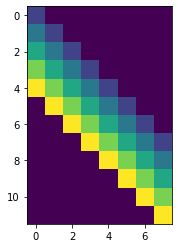

In [5]:
plt.imshow(H)

## Q4 b 

In [6]:
def cconv(x:np.array, y:np.array, N:int):
    return np.real(ifft(np.multiply(fft(x,N),fft(y,N))))


Verification

In [7]:
x = np.random.randint(0,5,(5))
y = np.random.randint(0,5,(4))
N = 8
res = cconv(x,y,N)
print("X = ",x,"\nY = ",y)
print("Linear convolution: ", np.convolve(x,y))
print("Circular convolution with N =", N, ":", res)
N = 6
res = cconv(x,y,N)
print("Circular convolution with N =", N, ":", np.round(res,2))


X =  [0 4 3 2 0] 
Y =  [4 0 0 1]
Linear convolution:  [ 0 16 12  8  4  3  2  0]
Circular convolution with N = 8 : [-8.8817842e-16  1.6000000e+01  1.2000000e+01  8.0000000e+00
  4.0000000e+00  3.0000000e+00  2.0000000e+00 -8.8817842e-16]
Circular convolution with N = 6 : [ 2. 16. 12.  8.  4.  3.]


## Q4 c

In [8]:
def  cconvmtx(h:np.array, N:int):
    I = np.eye(N)
    for i in range(N):
        I[:,i] = np.round(cconv(h,I[:,i].T,N).T,3)
    return I

In [9]:
h = np.random.randint(0,5,32)
N = 28
x = np.random.randint(0,5,N)
res = cconv(x,h,N)
H = cconvmtx(h,N)
res2 = np.matmul(H,x)
assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal may output False due to precision errors
print("All tests are success!")


All tests are success!


## Q4 d
### Verification 
* N values are swept from 4 to 64 and every case is asserted. 

In [10]:
for N in range(4,64):
    N = 16
    h = np.random.randint(0,12,N)
    x = np.random.randint(0,12,N)
    F = dft(N)
    X = np.matmul(F,x)
    H = np.matmul(F,h)
    res = np.matmul(inv(F),np.multiply(X,H))
    res2 = cconv(x,h,N)
    assert np.sum(np.isclose(res,res2)) == res.size # np.array_equal may output False due to precision errors
print("All tests are success!")

All tests are success!


## Q4 e

[[1. 0. 0. 3. 2.]
 [2. 1. 0. 0. 3.]
 [3. 2. 1. 0. 0.]
 [0. 3. 2. 1. 0.]
 [0. 0. 3. 2. 1.]]


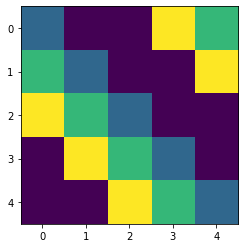

In [11]:
H = cconvmtx([1,2,3],5)
print(H)
plt.imshow(H)

[[ 6. -0.j  -0. -0.j  -0. +0.j   0. +0.j   0. -0.j ]
 [ 0. -0.j  -0.8-3.7j  0. -0.j  -0. +0.j   0. +0.j ]
 [-0. -0.j  -0. +0.j   0.3+1.7j  0. -0.j  -0. +0.j ]
 [ 0. -0.j   0. +0.j   0. -0.j   0.3-1.7j -0. +0.j ]
 [ 0. -0.j  -0. +0.j  -0. +0.j  -0. +0.j  -0.8+3.7j]]


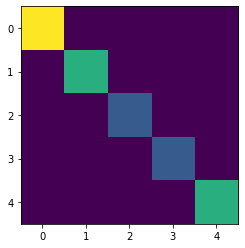

In [12]:
F = dft(5)
FCFH = np.round(F.dot(H).dot(inv(F)),1)
plt.imshow(np.abs(FCFH))
print(FCFH)

In [13]:
[E,P] = eig(H)
np.round(E,2)

array([ 6.  +0.j  , -0.81+3.67j, -0.81-3.67j,  0.31+1.68j,  0.31-1.68j])